In [193]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

In [194]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=160, frameon=False) 

scanpy==1.4.4 anndata==0.6.22.post1 umap==0.3.9 numpy==1.17.0 scipy==1.3.1 pandas==0.25.0 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


<h3>Data loading and preprocessing</h3>

In [195]:
data = sc.read_csv('/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/harmony/data/180831_raw-data_23428cells.csv')

In [196]:
metadata = pd.read_csv('/projects/pytrik/sc_adipose/analyze_10x_fluidigm/10x-adipocyte-analysis/output/harmony/data/180831_metadata_23428cells.csv', index_col=0)

In [197]:
all_obs = pd.concat([data.obs, metadata], axis=1, sort=False)
data.obs = all_obs

In [198]:
# only consider genes with more than 1 count
sc.pp.filter_genes(data, min_counts=1)

# normalize with total UMI count per cell
sc.pp.normalize_per_cell(data, key_n_counts='n_counts_all')

# select highly-variable genes
filter_result = sc.pp.filter_genes_dispersion(data.X, flavor='cell_ranger', n_top_genes=5000, log=False)

# subset the genes
data = data[:, filter_result.gene_subset] 

# renormalize after filtering
sc.pp.normalize_per_cell(data)

# log transform: adata.X = log(adata.X + 1)
sc.pp.log1p(data)               
sc.pp.scale(data)  

filtered out 63 genes that are detectedin less than 1 counts
normalizing by total count per cell
    finished (0:00:11): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:04)
normalizing by total count per cell


Trying to set attribute `.obs` of view, making a copy.


    finished (0:00:01): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [199]:
sc.tl.pca(data, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:13)


In [200]:
sc.pp.neighbors(data, n_neighbors=4, n_pcs=20)

computing neighbors
    using 'X_pca' with n_pcs = 20


/tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:03)


<h3>Visualization</h3>

ForceAtlas2 (default)

In [174]:
sc.tl.draw_graph(data)

drawing single-cell graph using layout 'fa'
    finished (0:03:03)


... storing 'orig.ident' as categorical
... storing 'timepoint' as categorical
... storing 'Phase' as categorical
... storing 'label' as categorical
... storing 'sample_name' as categorical
... storing 'type' as categorical
... storing 'depot' as categorical
... storing 'pc2.groups' as categorical
... storing 'pc2_supra_peri' as categorical
... storing 'pc2_subq_visce' as categorical
... storing 'State.old.labels' as categorical
... storing 'branch_low_res' as categorical
... storing 'branch_high_res' as categorical
... storing 'State.labels' as categorical
... storing 'State.names' as categorical
... storing 'branch' as categorical
... storing 'timepoint_depot' as categorical


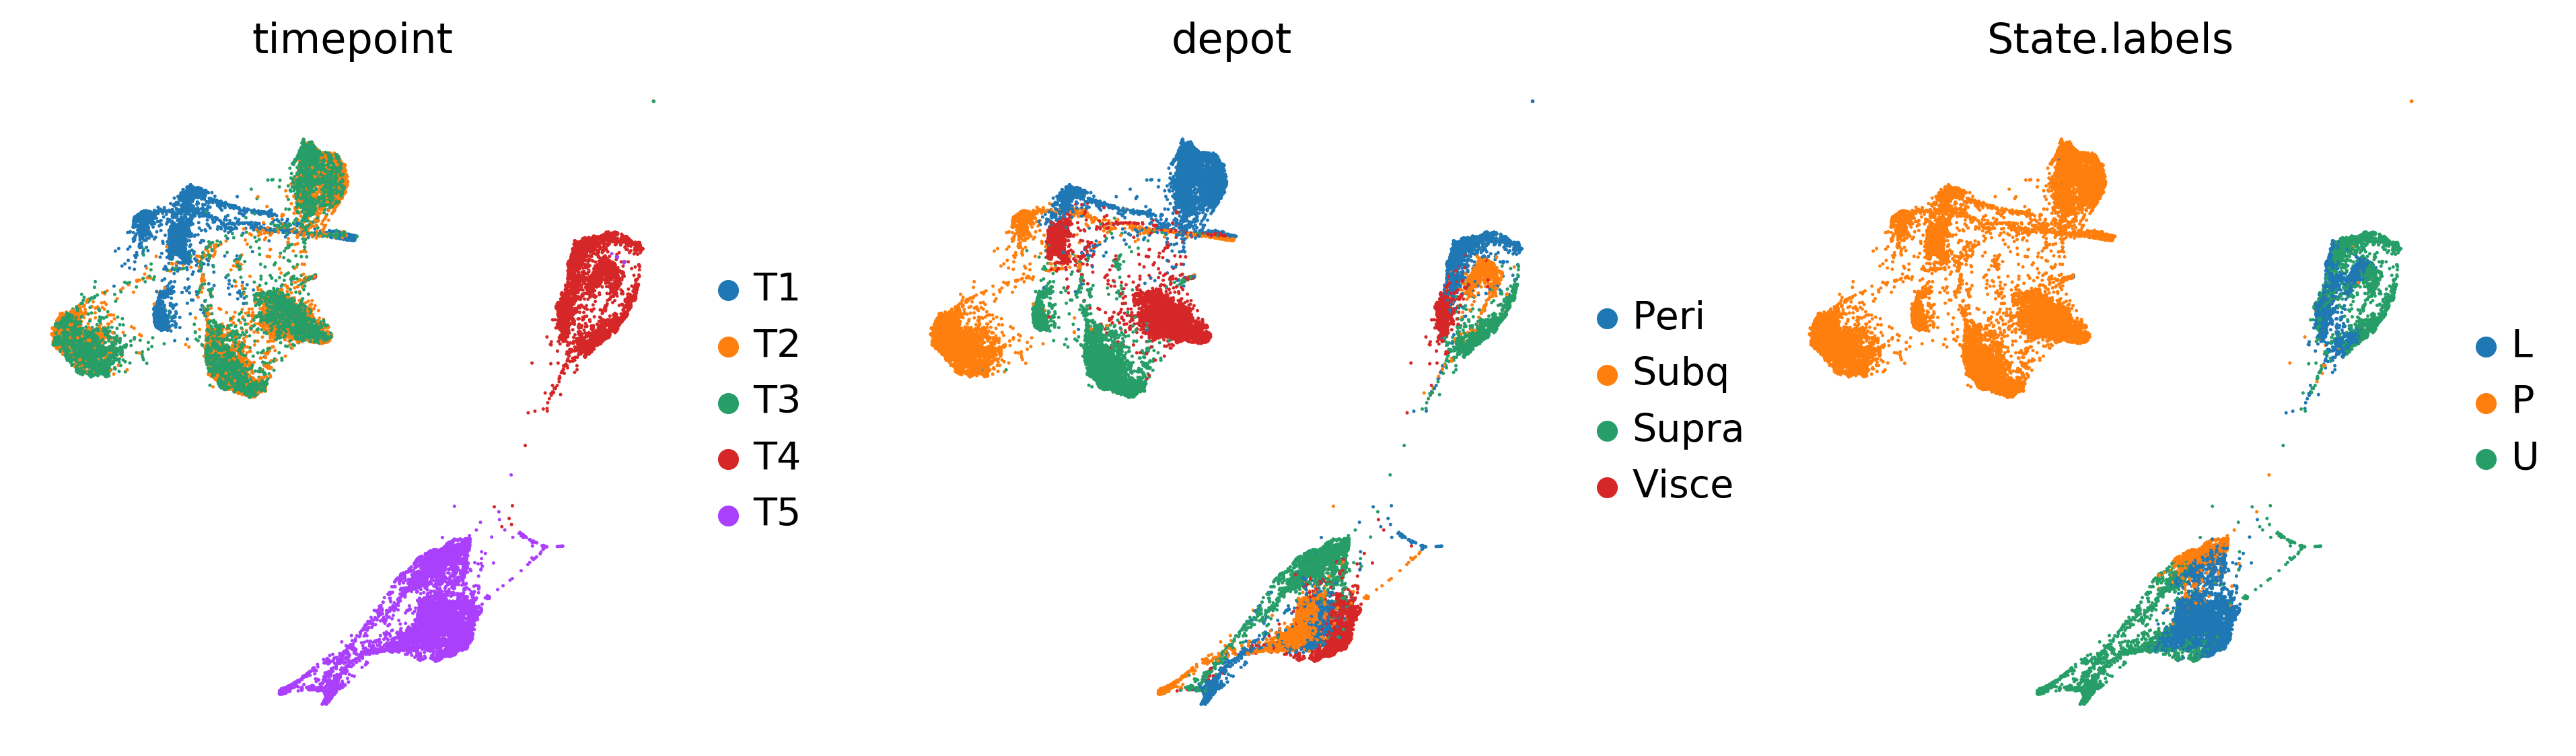

In [175]:
sc.pl.draw_graph(data, color=['timepoint', 'depot', 'State.labels'], legend_loc='right margin')

Large graph

In [177]:
sc.tl.draw_graph(data, layout='lgl')

drawing single-cell graph using layout 'lgl'
    finished (0:01:23)


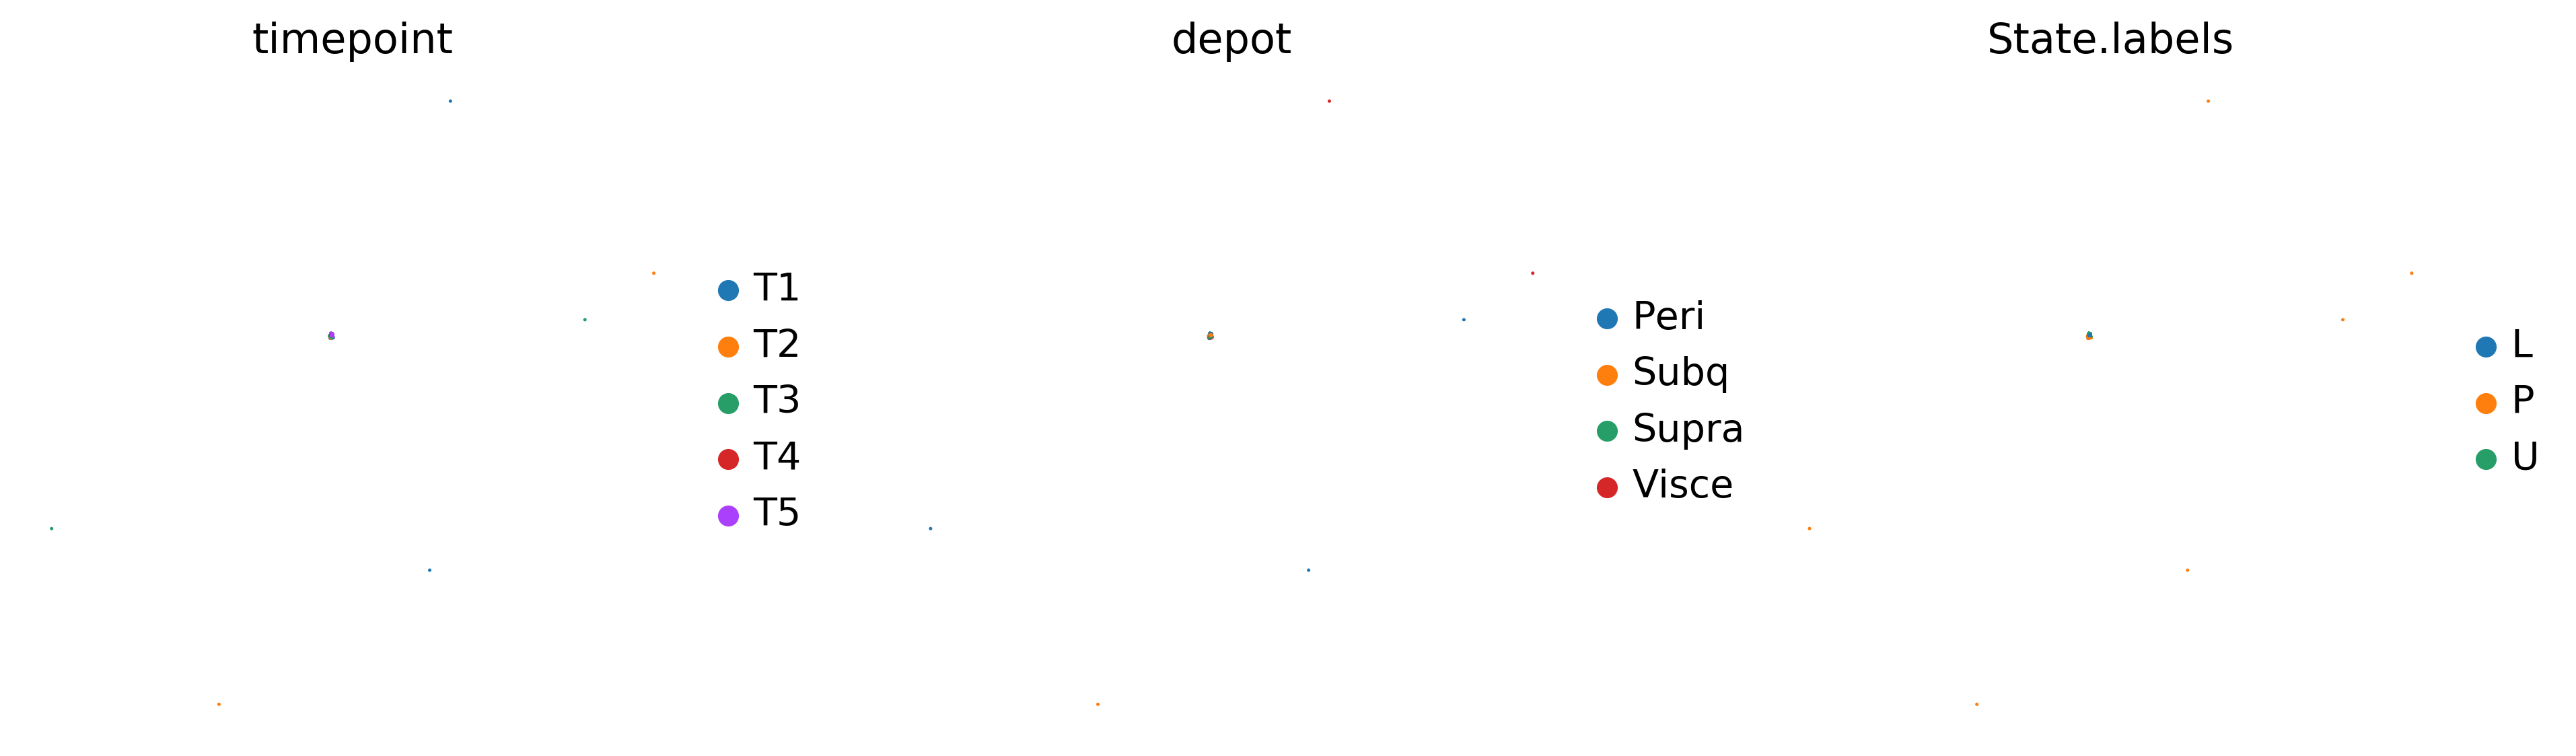

In [178]:
sc.pl.draw_graph(data, color=['timepoint', 'depot', 'State.labels'], legend_loc='right margin', layout='lgl')

...ok. Also tried Fruchterman Reingold but gave an error. Continuing with ForceAtlas2 layout. 

<h3>Denoising the graph</h3>

To denoise the graph, we represent it in diffusion map space (and not in PCA space). Computing distances within a few diffusion components amounts to denoising the graph - we just take a few of the first spectral components. It’s very similar to denoising a data matrix using PCA. The approach has been used in a couple of papers, see e.g. Schiebinger et al. (2017) or Tabaka et al. (2018). It’s also related to the principles behind MAGIC Dijk et al. (2018).

In [179]:
sc.tl.diffmap(data)
sc.pp.neighbors(data, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9999992  0.99960905 0.99805    0.99794626
     0.99783397 0.99686325 0.9968513  0.9962012  0.9953572  0.9946118
     0.9933719  0.99319714 0.9927571 ]
    finished (0:00:03)
computing neighbors


/tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:03)


In [180]:
sc.tl.draw_graph(data)

drawing single-cell graph using layout 'fa'
    finished (0:03:13)


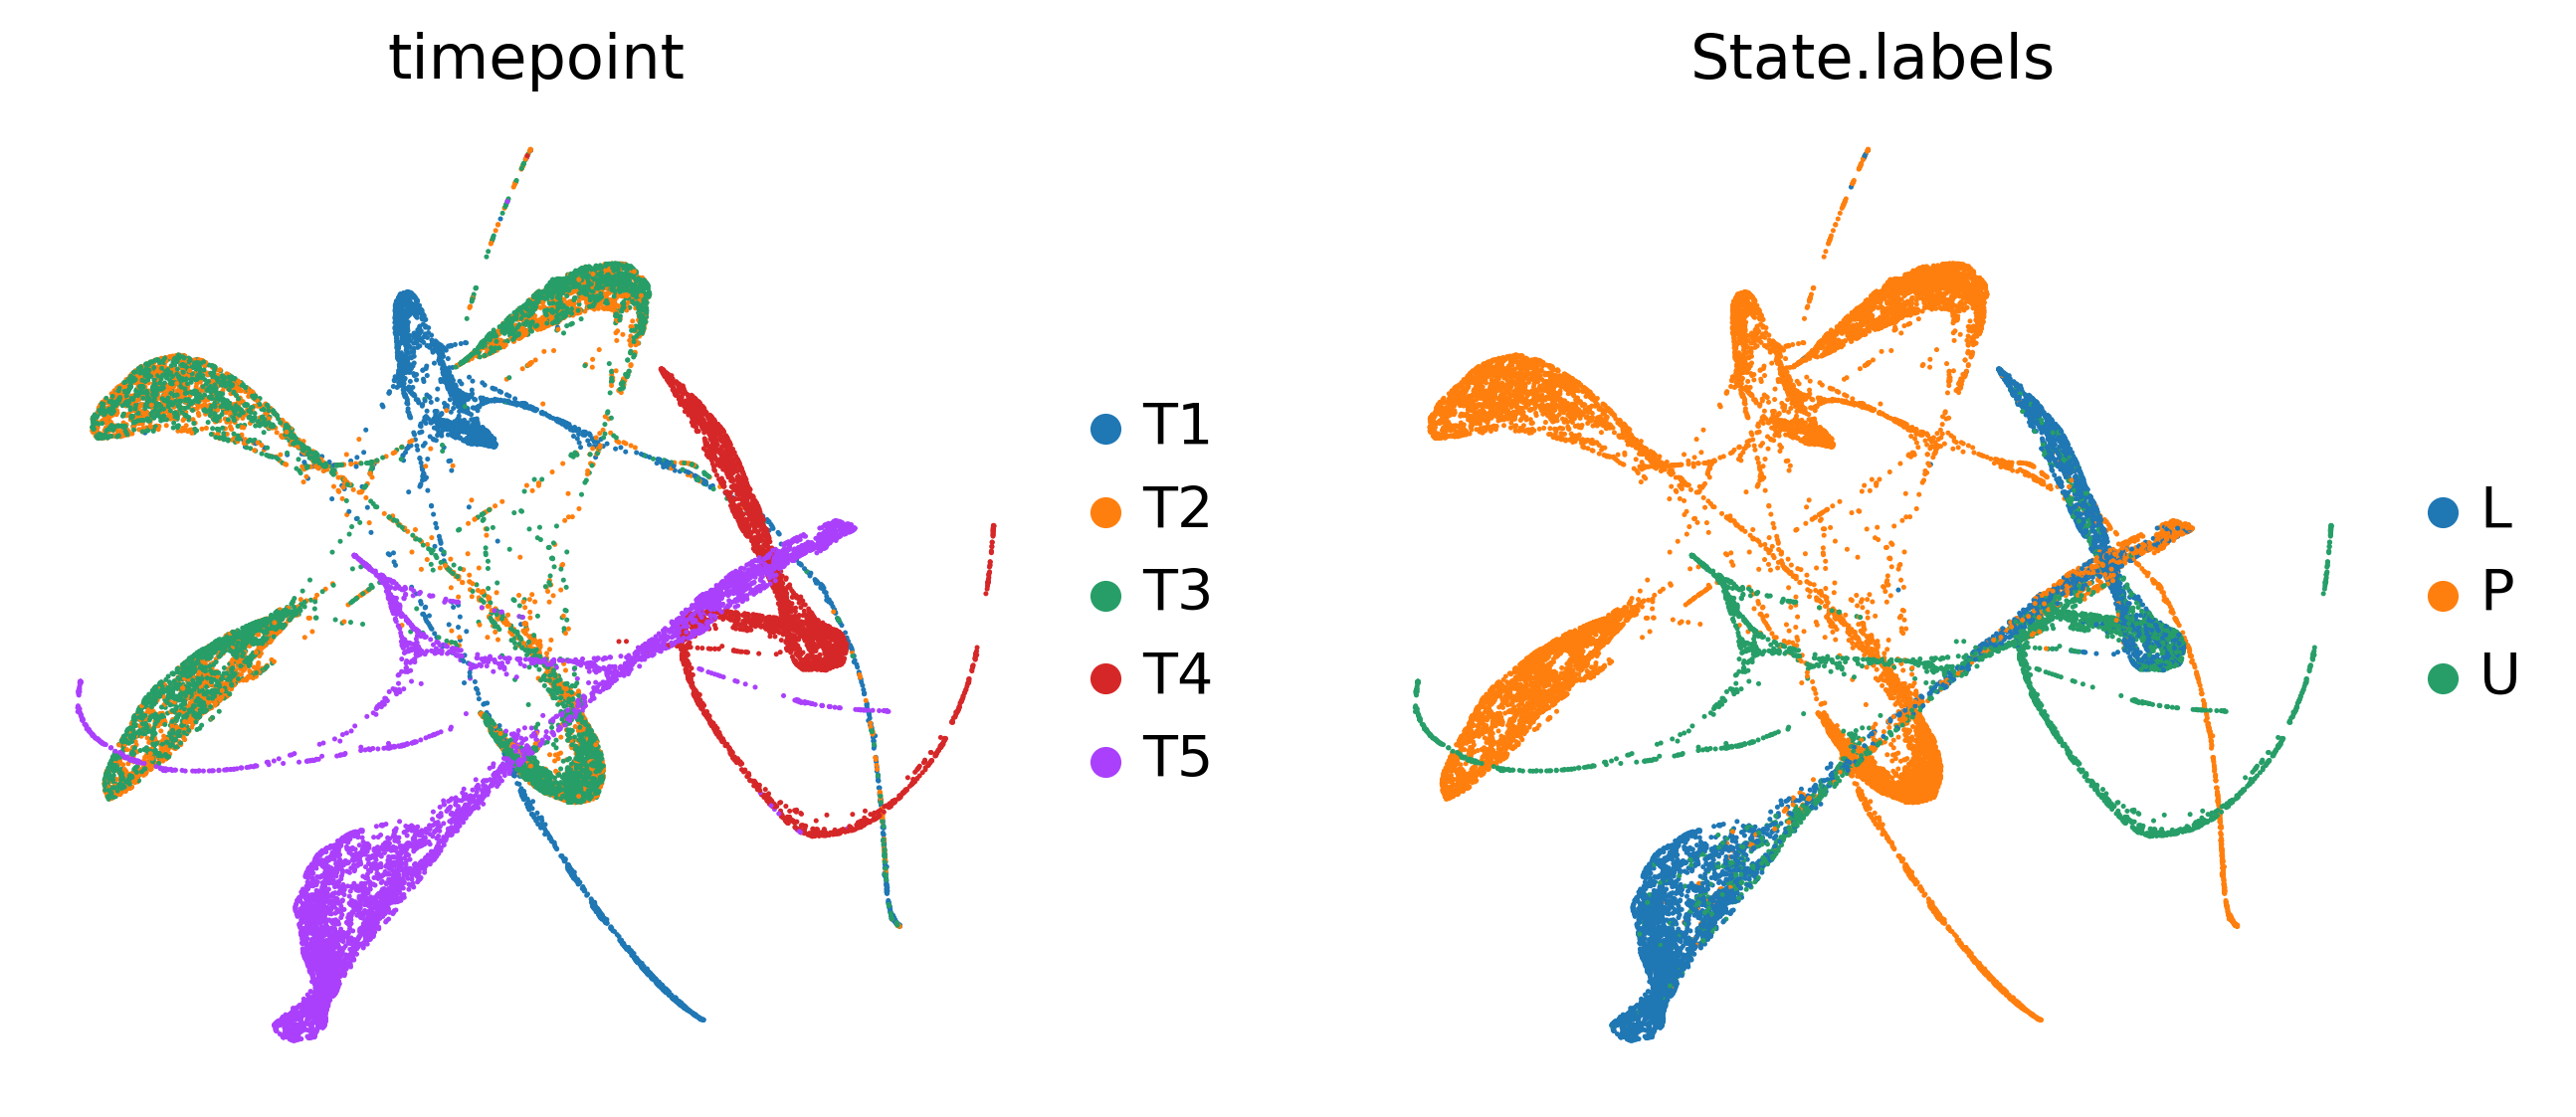

In [181]:
sc.pl.draw_graph(data, color=['timepoint', 'State.labels'], legend_loc='right margin')

<h3>Clustering and PAGA</h3>

In [201]:
sc.tl.louvain(data, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00)


For simple, coarse-grained visualization, compute the PAGA graph, a coarse-grained and simplified (abstracted) graph. Non-significant edges in the coarse- grained graph are thresholded away.

In [202]:
sc.tl.paga(data, groups='louvain')

... storing 'orig.ident' as categorical
... storing 'timepoint' as categorical
... storing 'Phase' as categorical
... storing 'label' as categorical
... storing 'sample_name' as categorical
... storing 'type' as categorical
... storing 'depot' as categorical
... storing 'pc2.groups' as categorical
... storing 'pc2_supra_peri' as categorical
... storing 'pc2_subq_visce' as categorical
... storing 'State.old.labels' as categorical
... storing 'branch_low_res' as categorical
... storing 'branch_high_res' as categorical
... storing 'State.labels' as categorical
... storing 'State.names' as categorical
... storing 'branch' as categorical
... storing 'timepoint_depot' as categorical


running PAGA
    finished (0:00:01)


--> added 'pos', the PAGA positions (adata.uns['paga'])


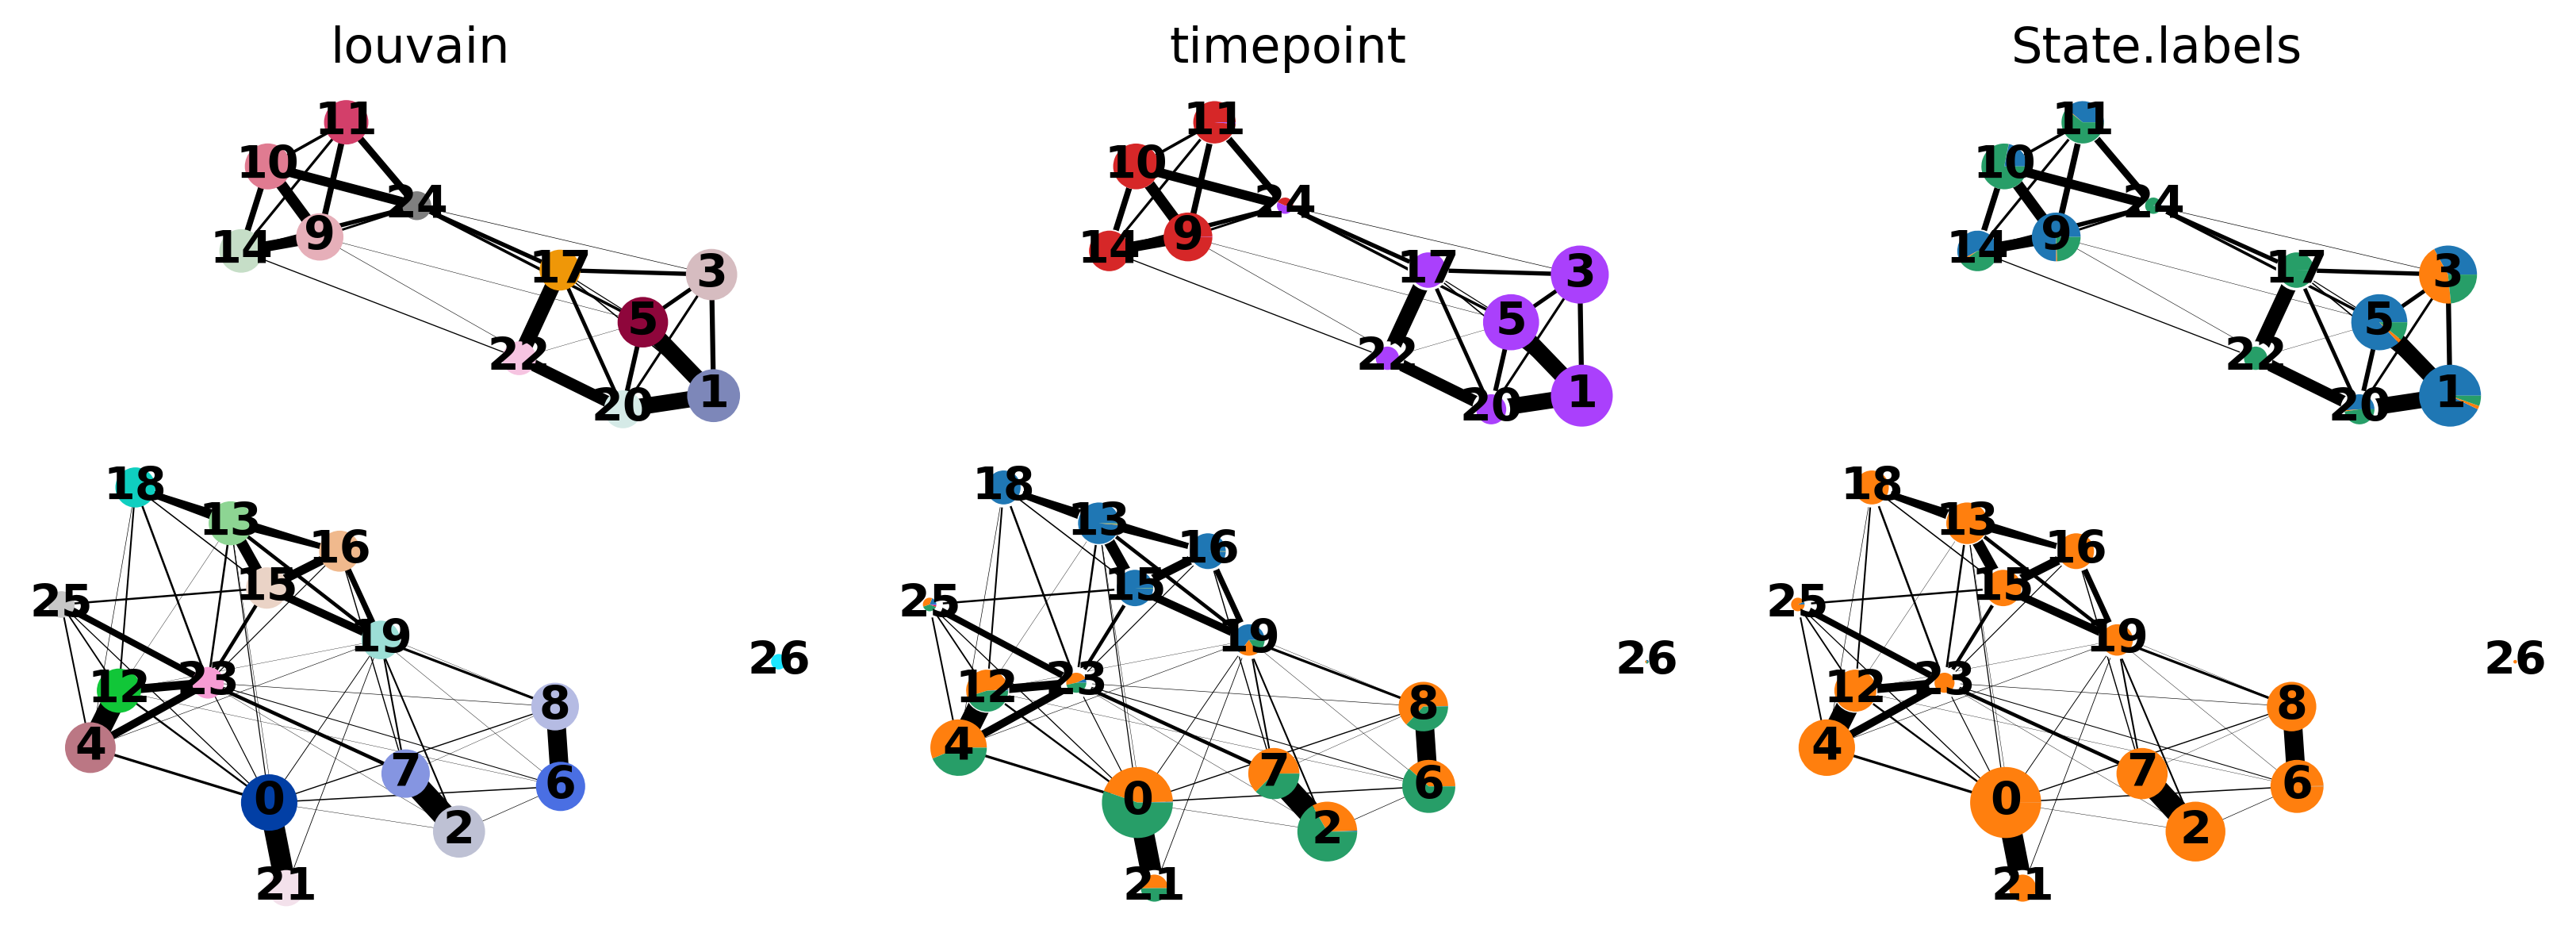

In [203]:
sc.pl.paga(data, color=['louvain', 'timepoint', 'State.labels'])

/tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_

--> added 'pos', the PAGA positions (adata.uns['paga'])


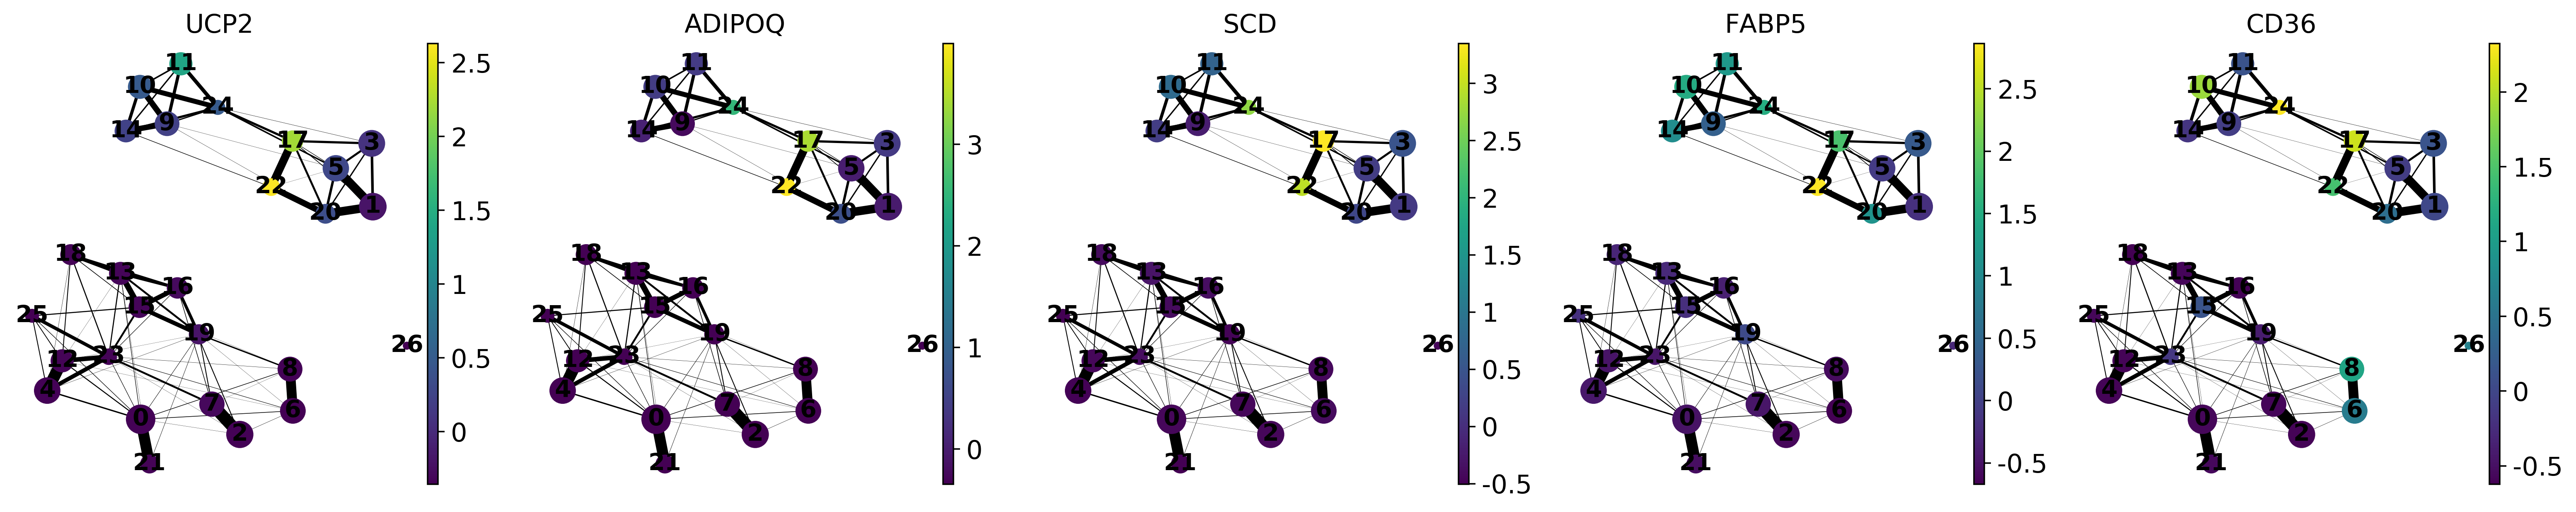

In [204]:
sc.pl.paga(data, color=['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36'])

/tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/tools/anaconda/envs/pytrik/py37/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_

--> added 'pos', the PAGA positions (adata.uns['paga'])


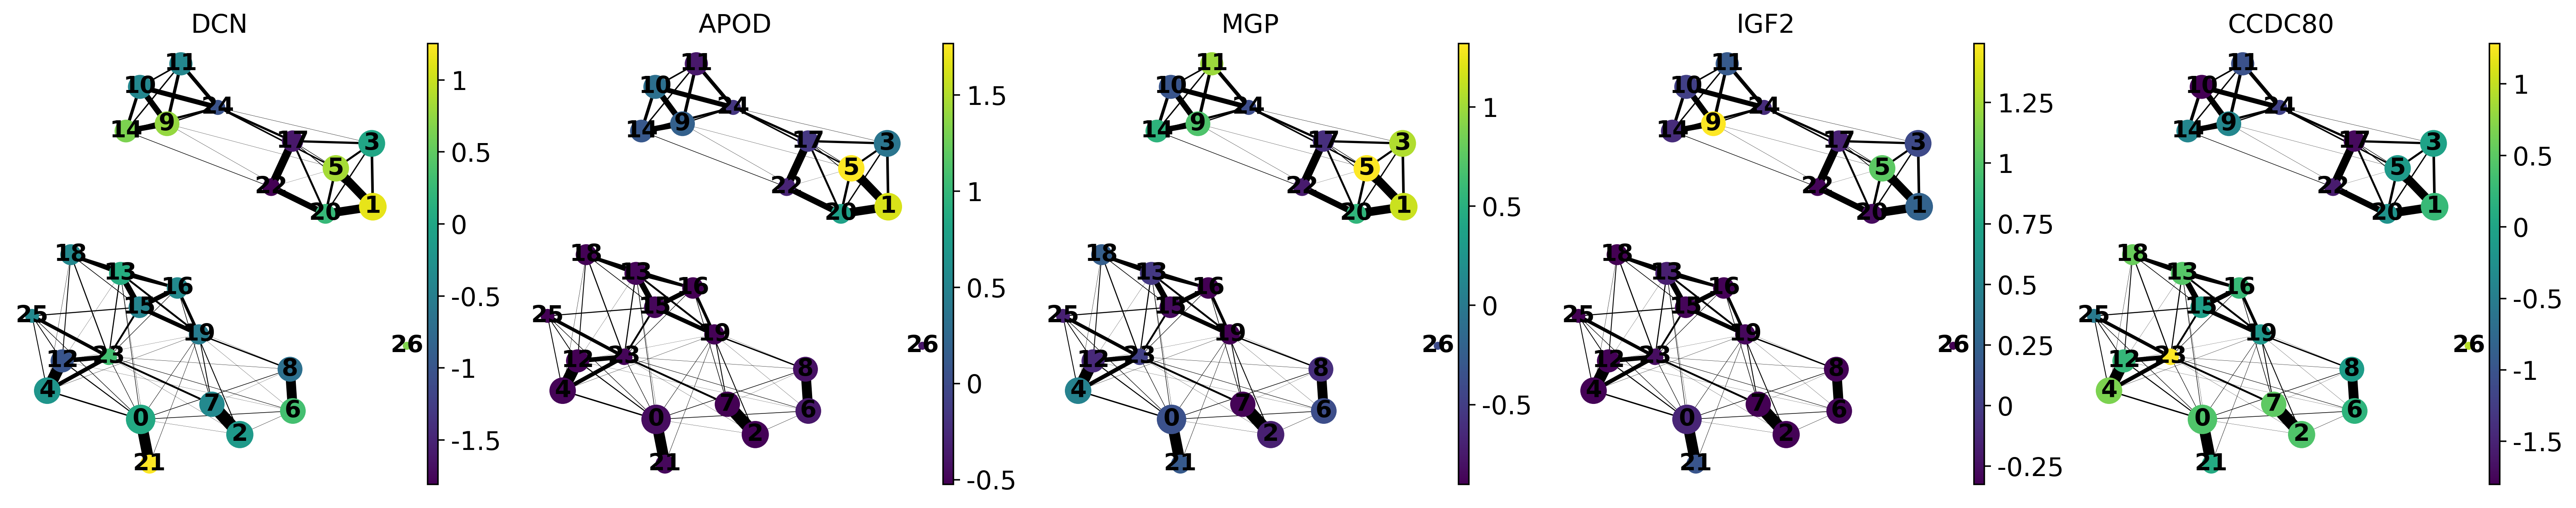

In [205]:
sc.pl.paga(data, color=['DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'])

<h3>Recomputing the embedding using PAGA-initialization</h3>

In [206]:
sc.tl.draw_graph(data, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished (0:03:00)


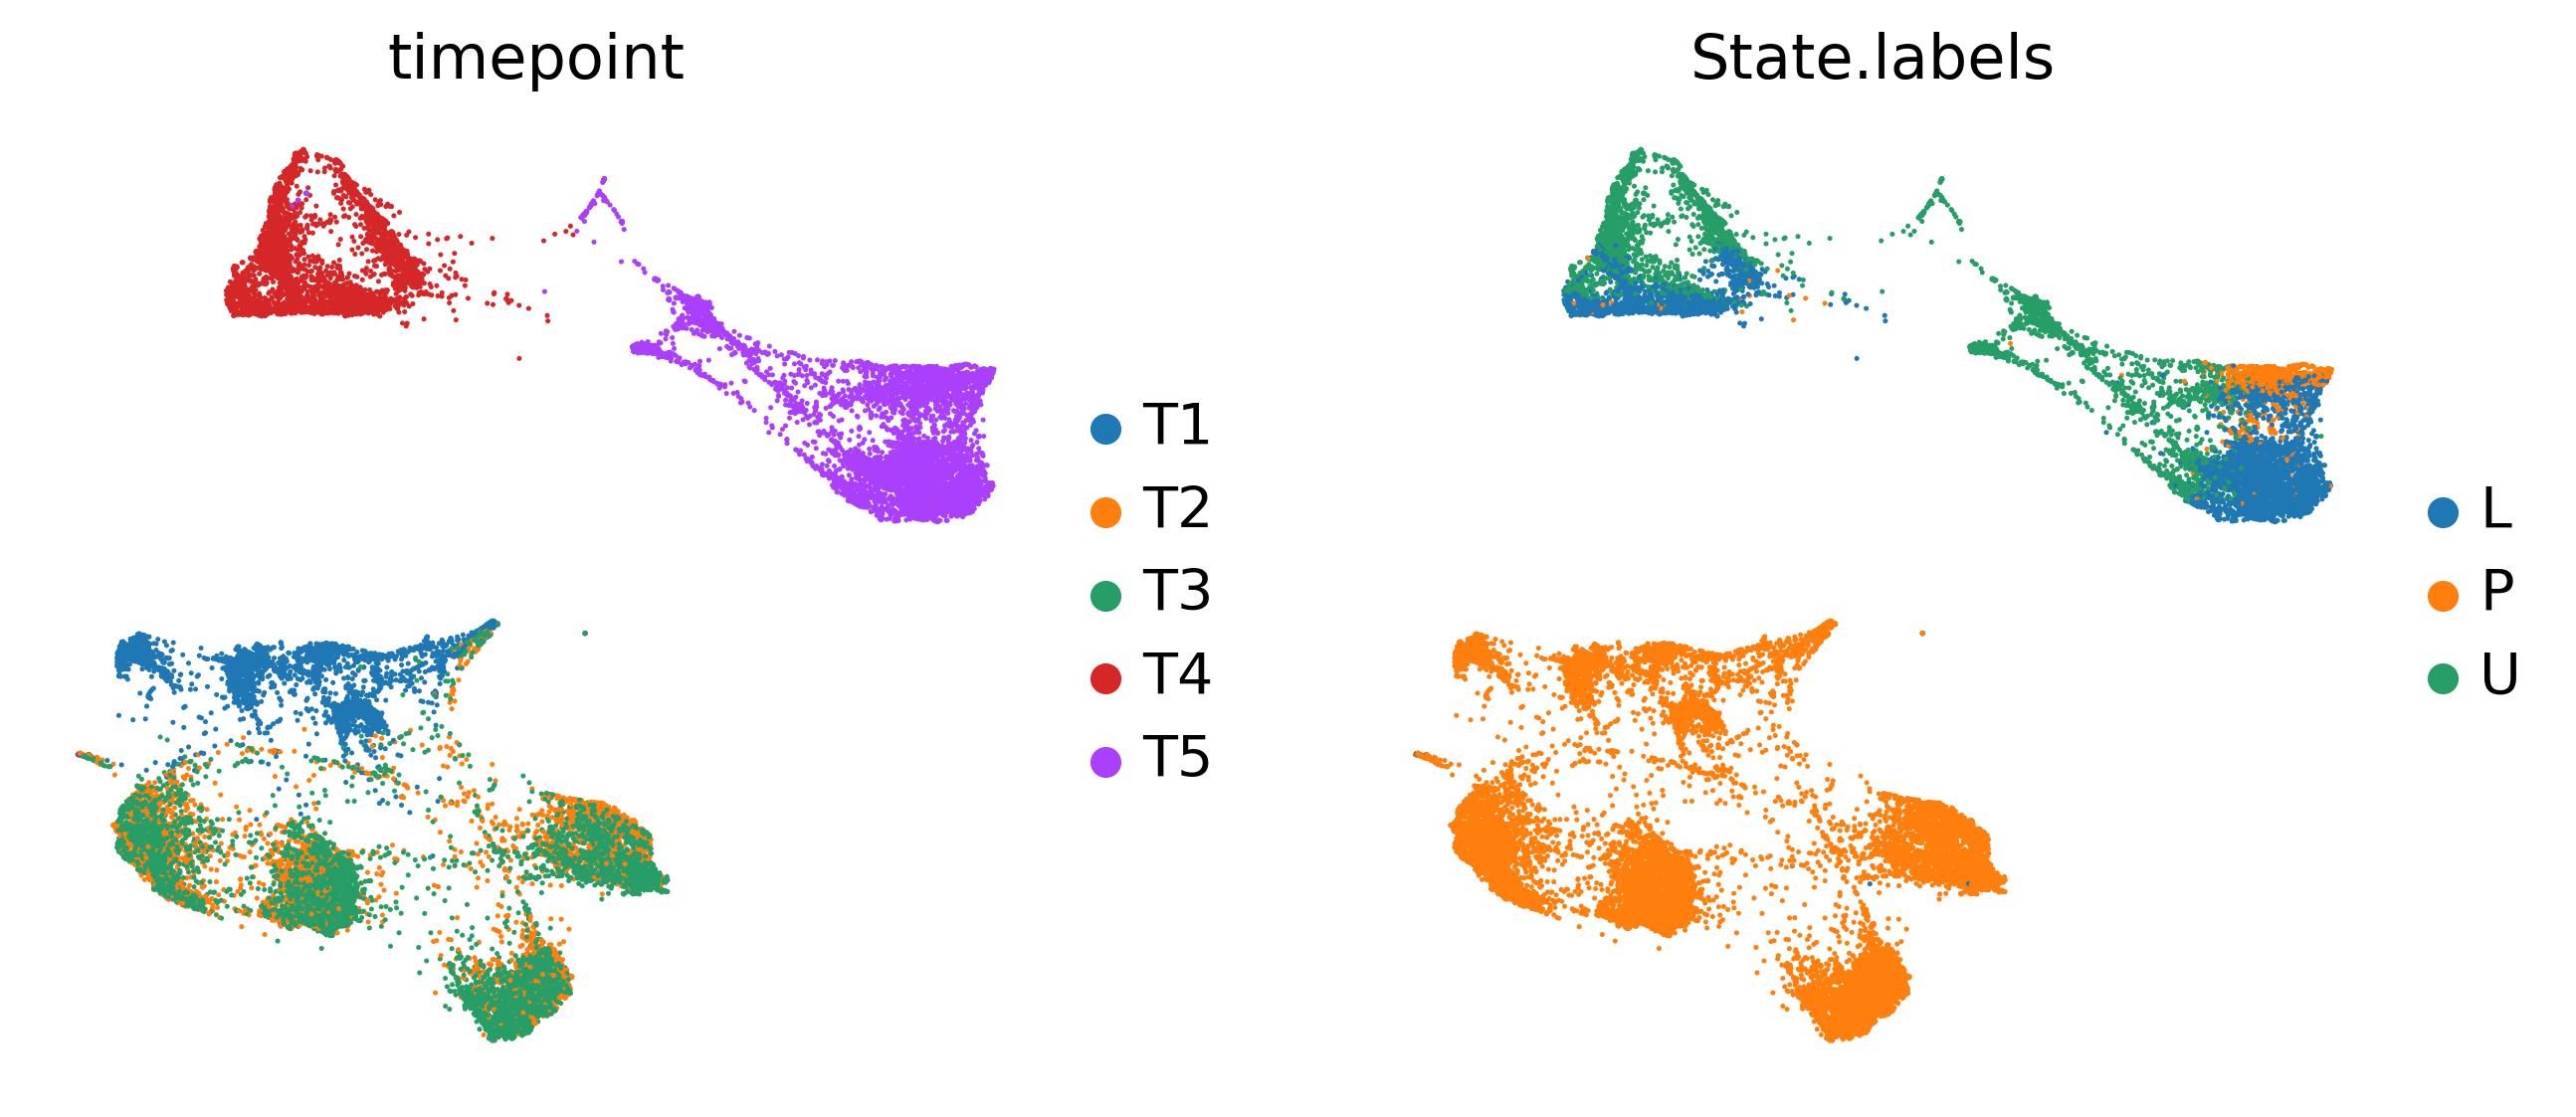

In [207]:
sc.pl.draw_graph(data, color=['timepoint', 'State.labels'], legend_loc='right margin')

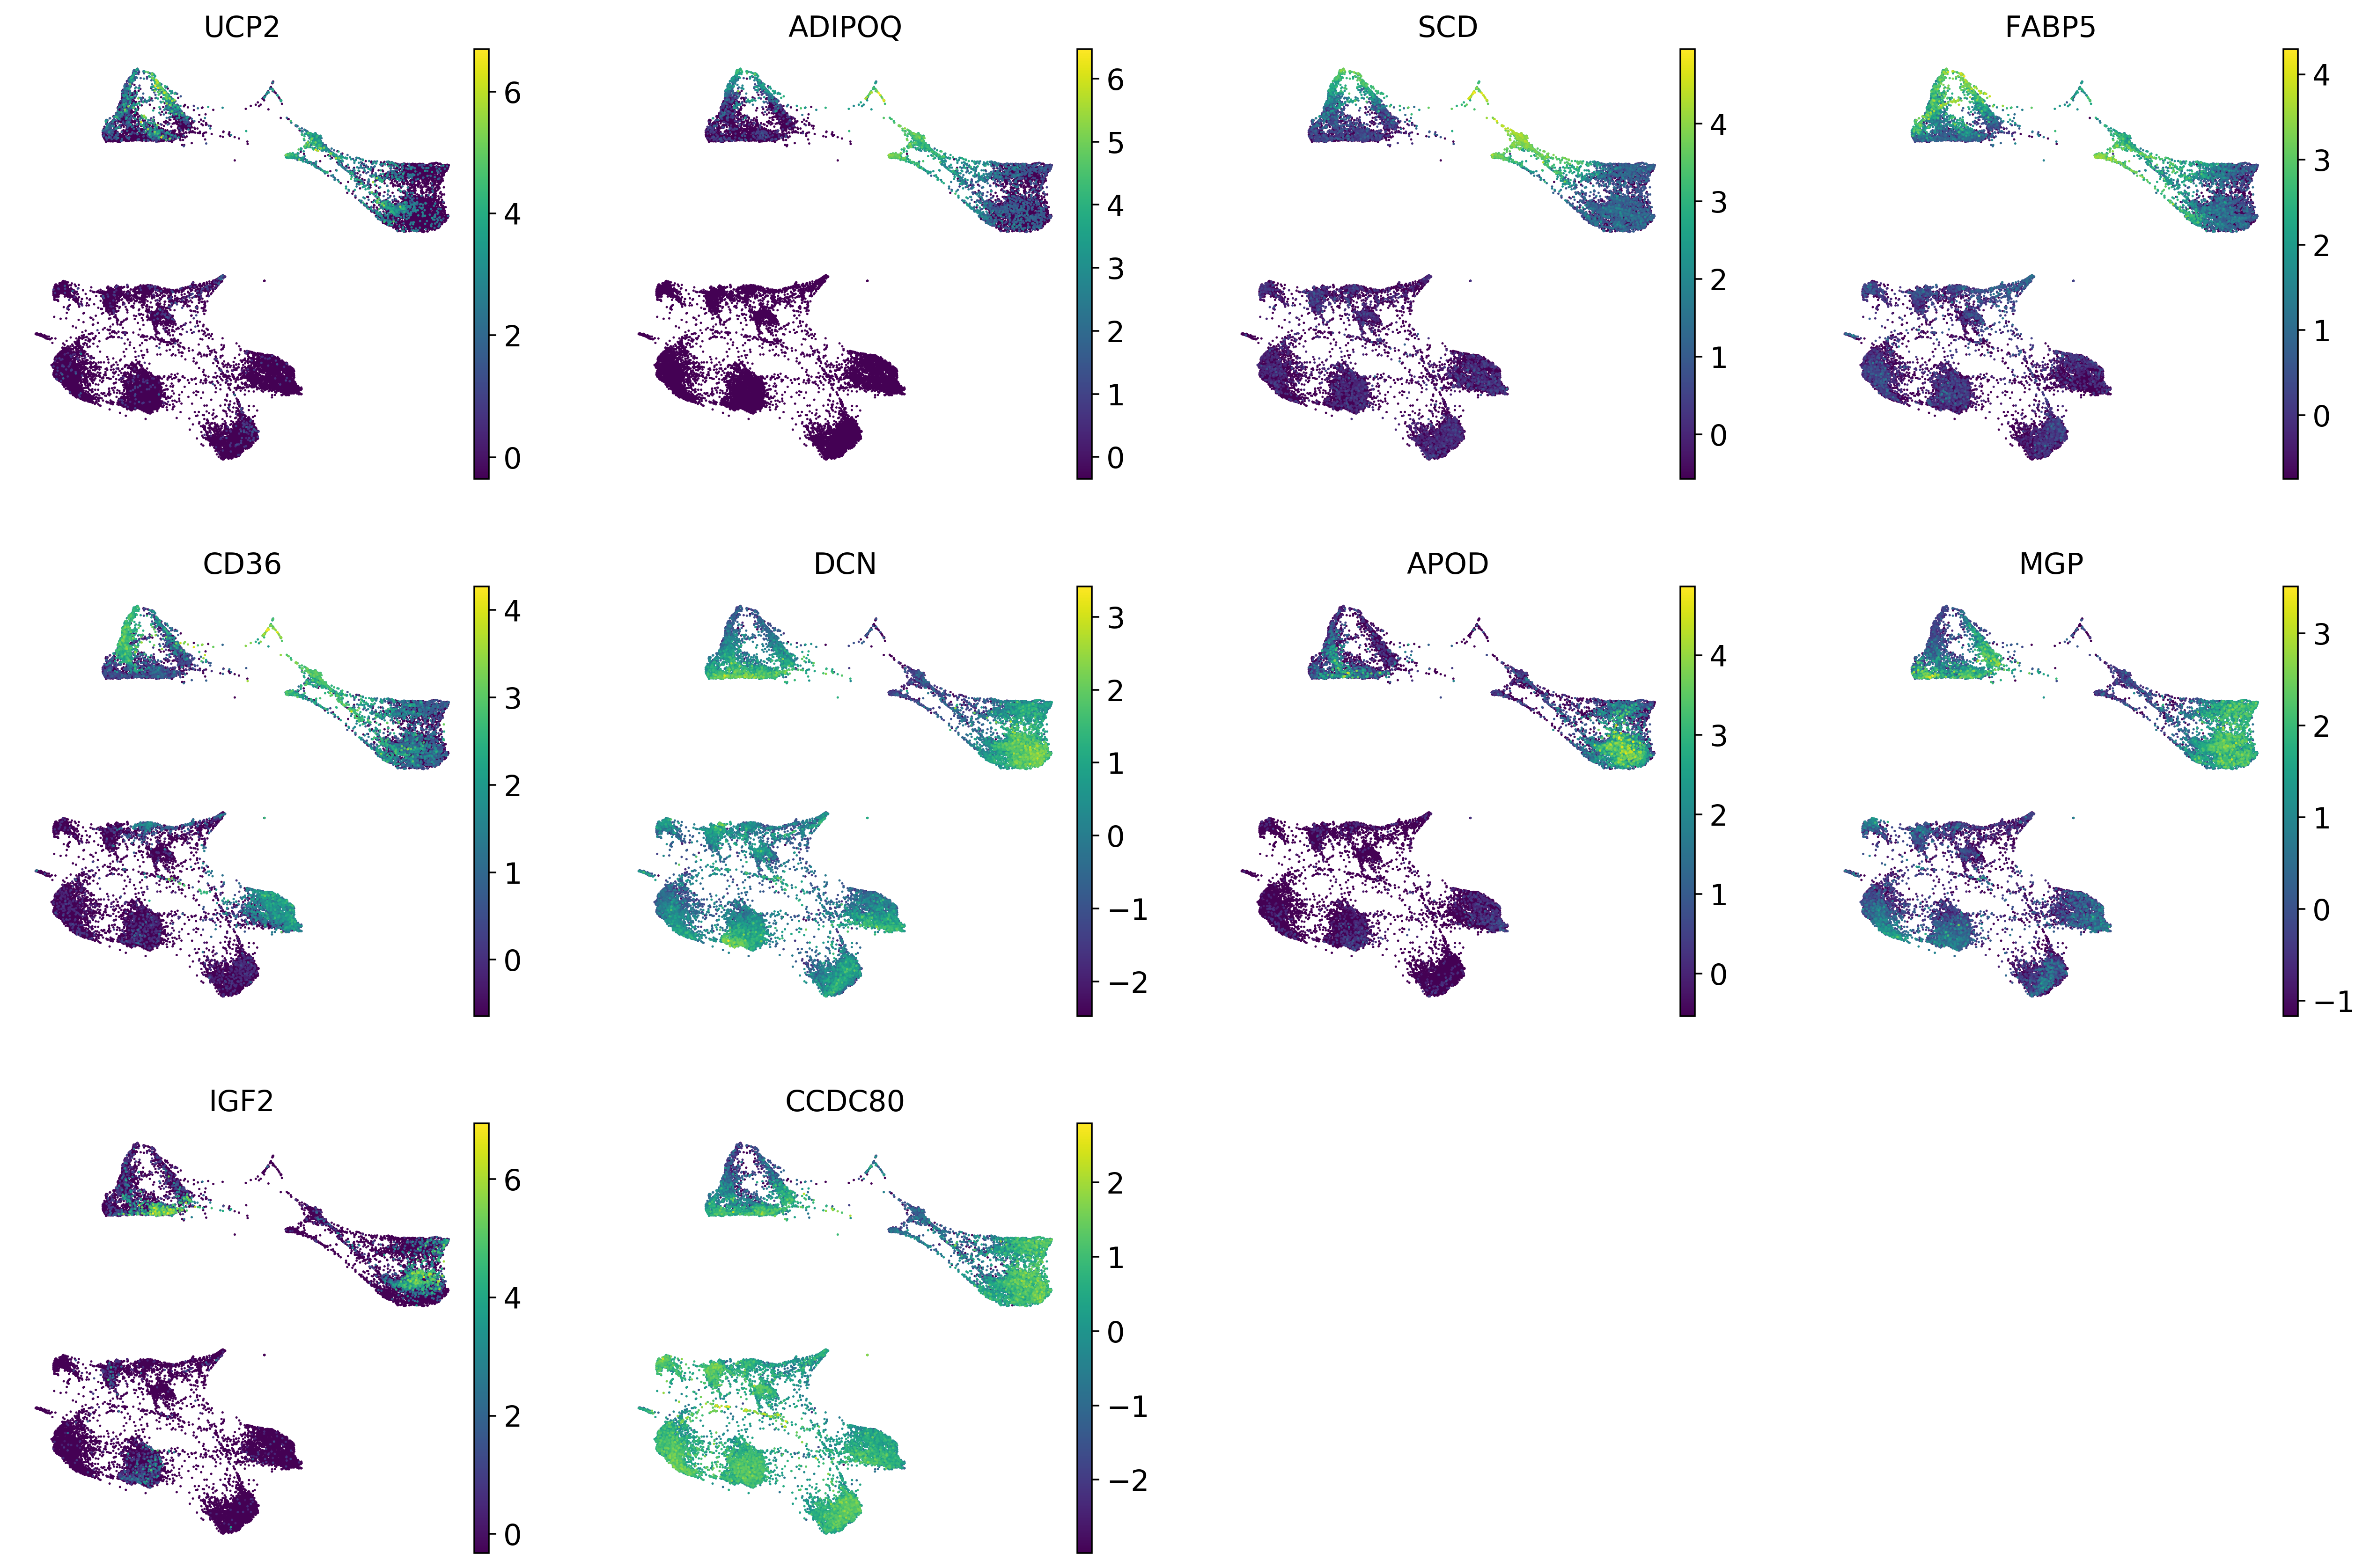

In [208]:
sc.pl.draw_graph(data, color=['UCP2', 'ADIPOQ', 'SCD', 'FABP5', 'CD36','DCN', 'APOD', 'MGP', 'IGF2', 'CCDC80'], legend_loc='right margin')